## Success Metrics: Differences in Click Thru' Rates (CTRs)

#### Let's say we have a control variant called it A, and a test variant called it B.

The statistical difference between in click thru' rate between A and B is shown below

<!--  -->


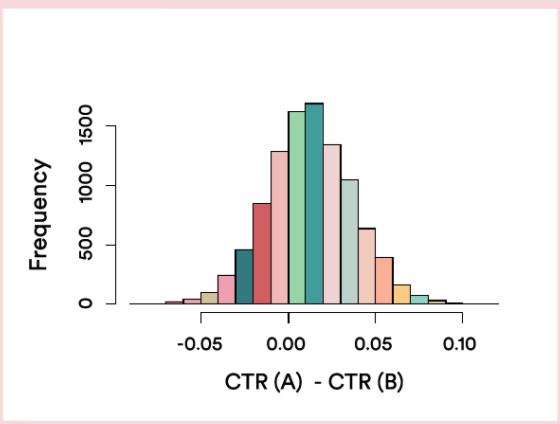

Note that most of the distribution is to the right of 0. Meaning there is an empirical evidence that A has a higher CTR than B. The usual objective of this very test is to find the Probability To Be The Best (P2BB). In Figure 1, the P2BB is 0.699, in favor of A.

No matter how many variants you wanted to compare, you can always find out the P2BB of each variant. Hope that makes sense!

## Length of time (or duration) of the experiment

With all the factors other than finding a time frame that has no external events that would otherwise affect the metrics of interest which is the basis of the experiment, there exists a consideration to suggest a minimum time frame for running an experiment that ensures representative coverage in the A/B test of normal future site visitors. 
And that's the recipe for finding the length, or duration, the experiment.

## Sample size calculations

As the intent of this blog post isn't to reinvent the wheel for sample size calculations, I'd refer the audience to the following widget that is found at a site called dyLabs.

[Bayesian A/B Test Duration & Sample Size Calculator](https://marketing.dynamicyield.com/ab-test-duration-calculator/?_ga=2.182222695.177277132.1646363141-753160201.1643135482)


<!--  -->

#### Possible success metrics: Click Thru Rates(CTRs), installation rates, revenue per visitor, revenue per convension

## Can you stop a test early?

The rule of thumb is a strong signal from the P2BB statistic can be used to guide early stopping. However, early stopping needs to be done with caution. What that means is we can make the decision to stop if the probability is at .999 or .001. But anything short of those extreme cases, it depends on how the percetage of P2BB is trending.

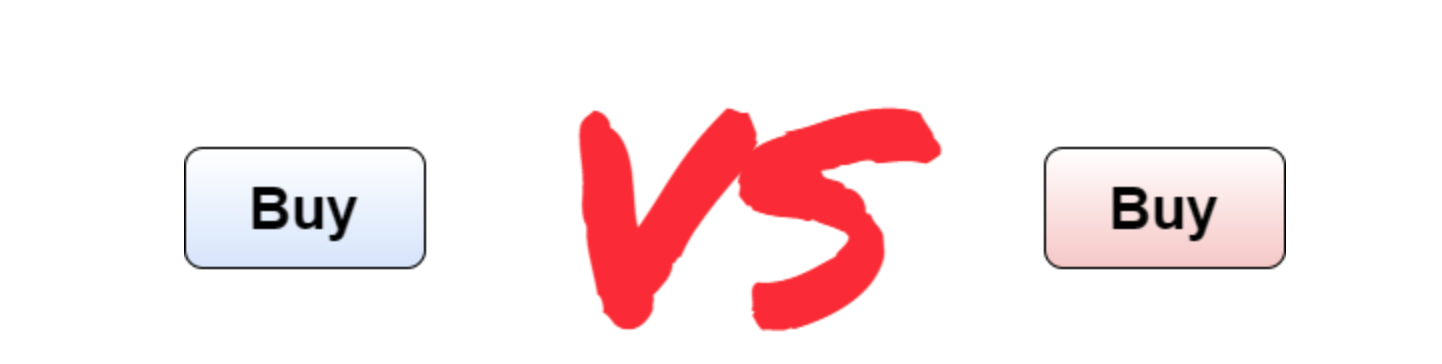

### Task:

Randomly assign new visitors to your Cloud-based eCommerce store to 50% apiece for the Blue Buy Button as the Call-To-Action (CTA), control variant, and Red Buy Button as the CTA, test (or treatment) variant.

### Hypothesis: 

You get a better conversion (a lift) with the Red Buy Button as the CTA.

With 100K visitors, we randomly split them into the 2 variants, control & test.

In [1]:
import numpy as np
np.random.seed(8)
blue_conversions = np.random.binomial(1, 0.01, size=49999)
red_conversions = np.random.binomial(1, 0.0089, size=50001)

As the distribution is binomial, the outcomes are 0s and 1s. 0 means no click. 1 means there is a click event.

In [2]:
print(blue_conversions)

print(red_conversions)


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [3]:
print(f'Blue: {blue_conversions.mean():.3%}')
print(f'Red: {red_conversions.mean():.3%}')


Blue: 1.028%
Red: 0.908%


Note that you can tell the blue button has a higher conversion rate at 1.028% where the red button converts at 0.908%

So even tho' we saw that blue (control variant) performs better and red is slightly behind in terms of conversion rates. The task at hand would be to truly follow thru' on the hypothesis and see if happens merely by chance. 

Again here is the hypotheis,

H0: blue is better
H1: red is better

In [4]:
# !pip install arviz==0.11.0

In [5]:
import pymc3 as pm


bernoulli = pm.Model()
with bernoulli:
    blue_rate = pm.Beta('blue_rate', 1, 99)
    red_rate = pm.Beta('red_rate', 1, 99)
    
    blue_obs = pm.Bernoulli('blue_obs', blue_rate, observed=blue_conversions)
    red_obs = pm.Bernoulli('red_obs', red_rate, observed=red_conversions)
    
    trace = pm.sampling.sample(random_seed=8, return_inferencedata=True)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [red_rate, blue_rate]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.


The priors were defined by blue_rate and red_rate respectively. 
Then we initialized the model with the built-in Bernoulli functions and pass the observed parameter with the variables created above, namely, blue_conversions and red_conversions. They stored the outcomes of the events, if you recalled.
At the end, we ended up using the given sample function from the PyMC3 package, which gives us the calculations for Beyesian Inference.

array([<AxesSubplot:title={'center':'blue_rate'}>,
       <AxesSubplot:title={'center':'red_rate'}>], dtype=object)

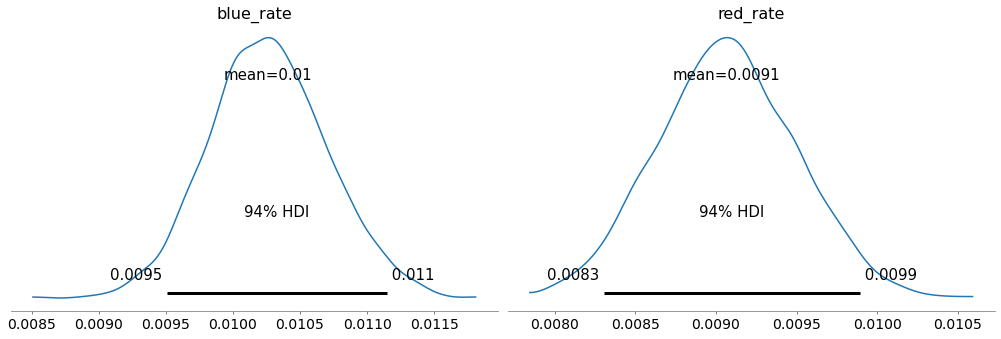

In [6]:
import arviz as az
az.plot_posterior(trace)

With the trace object, we can use the ArviZ, the visualization library, to help with visualizing the underlying posterior distributions of the conversion rates.

Note: The acronym HDI is short for High Density Interval.

### Commentaries:

With the 2 HDIs and the visualizations presented above, what that essentially means is blue conversion rates is between 0.95% and 1.1% 94% of the times while red conversion rates is between .84% and .99% 94% of the times. Blue button has a MLE conversion rate of 1% while red button has a MLE conversion rate of 0.9%.

In [8]:
blue_rate_samples = trace.posterior['blue_rate'].values
red_rate_samples = trace.posterior['red_rate'].values
print(f'Probability that red is better is: {(red_rate_samples > blue_rate_samples).mean():.1%}.')


Probability that red is better is: 2.3%.


#### The takeaway is the probability that the treatment variant (red button) is better than the control variant (blue button) is 2.3%. The red button is better with a probability of around 2%. The business actionable insights (or decision) is we don't want to implement the red button.

## Appendix

A closer look into the trace object

In [9]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### MAP estimate

In [12]:
map_estimate = pm.find_MAP(model=bernoulli)
map_estimate

{'blue_rate_logodds__': array(-4.56917658),
 'red_rate_logodds__': array(-4.69455192),
 'blue_rate': array(0.01026013),
 'red_rate': array(0.00906209)}

## References

https://towardsdatascience.com/bayesian-a-b-testing-in-pymc3-54dceb87af74

https://www.dynamicyield.com/lesson/running-effective-bayesian-ab-tests/